In [10]:
#---------------------------------------------
# XGBoost Example for Financial Prediction
# Author: Jamie Crossman-Smith
# Date: 23/03/2024

# This script is designed to demonstrate the application of the XGBoost classifier for a financial prediction task,
# specifically predicting whether a stock's closing price will be higher or lower than its opening price based onsimulated
# historical data. The process encompasses data generation, preprocessing, model training with hyperparameter tuning,
# evaluation, and interpretation, providing a comprehensive overview of a machine learning pipeline.

# Notes:
# StandardScaler is used to normalise the feature set, which is particularly important for models that are 
# sensitive to the scale of the data, such as logistic regression, but less so for tree-based models. 
# However, normalising can still speed up convergence and improve interpretability.
# The choice of hyperparameters and the use of GridSearchCV with cross-validation are crucial steps to find 
# the optimal model configuration, balancing the trade-off between bias and variance, or underfitting and overfitting.
# The evaluation metrics provide a comprehensive view of the model's performance from different perspectives, 
# highlighting areas of strength and potential improvement.
# Visualisations such as the feature importance plot, confusion matrix, ROC curve, and Precision-Recall curve 
# offer insights into what the model has learned and how it makes decisions, crucial for model evaluation and interpretation.
# SHAP values provide a powerful framework for explaining individual predictions, offering insights into the 
# contribution of each feature to the model's output, enhancing the transparency and accountability of machine learning models.
# ---------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             log_loss, matthews_corrcoef, confusion_matrix, RocCurveDisplay,
                             PrecisionRecallDisplay)
import shap  # Import SHAP for model interpretability

In [11]:
# Create a simple synthetic data set for the analysis. 

# Setting a random seed ensures reproducibility of the results
np.random.seed(42)

def generate_stock_data(num_days):
    
    # Generates synthetic stock data with added noise to simulate real-world unpredictability in stock movements.
    # Features include daily price changes, volume changes, and temporal features such as the day of the week.
    # The target variable indicates if the stock closed higher (1) or lower (0) than its opening price.

    dates = pd.date_range(start='2018-01-01', periods=num_days)
    prices = np.random.lognormal(mean=0.001, sigma=0.02, size=num_days) + 100  # Simulating stock prices
    volumes = np.random.randint(100000, 1000000, size=num_days)  # Simulating trading volumes
    noise = np.random.normal(0, 0.05, num_days)  # Adding noise for realism

    # Creating a DataFrame with all the features and the target variable
    df = pd.DataFrame({'Date': dates, 'Close': prices, 'Volume': volumes})
    df['Prev Close'] = df['Close'].shift(1) + noise
    df['Change from Prev Close'] = ((df['Close'] + noise) - df['Prev Close']) / df['Prev Close']
    df['Opening Gap'] = ((df['Close'] + noise) - df['Prev Close']) / df['Prev Close']
    df['Volume Change'] = ((df['Volume'] + np.random.randint(-5000, 5000, num_days)) - df['Volume'].shift(1)) / df['Volume'].shift(1)
    df['Day of Week'] = df['Date'].dt.dayofweek
    df['Week of Year'] = df['Date'].dt.isocalendar().week
    df['Month'] = df['Date'].dt.month
    df['Target'] = (((df['Close'] + noise) > df['Prev Close']) & (np.random.rand(num_days) > 0.5)).astype(int)
    
    df.dropna(inplace=True)  # Ensuring no missing values
    return df.drop(['Date', 'Close', 'Prev Close', 'Target'], axis=1), df['Target']

# Data generation and splitting
X, y = generate_stock_data(1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Machine Learning using XGBoost

# Defining Hyperparameters for GridSearchCV
# This section defines a grid of hyperparameters to explore. The goal is to find the best combination of parameters that leads to the most accurate model.

param_grid = {
    # 'max_depth': Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
    # Optimal values usually depend on the interactions of the input variables and usually range from 3 to 10.
    'max_depth': [3, 4, 5],

    # 'learning_rate' (also known as 'eta'): Step size shrinkage used to prevent overfitting. After each boosting step, we can directly get the weights of new features,
    # and eta shrinks the feature weights to make the boosting process more conservative.
    # A lower value requires more trees but can lead to a more accurate model.
    'learning_rate': [0.1, 0.01],

    # 'n_estimators': Number of boosting rounds or trees to build. Too many trees can lead to overfitting, so it must be tuned with the learning rate.
    # This represents the number of trees that are built sequentially to correct the errors of previous trees.
    'n_estimators': [100, 150],

    # 'subsample': The fraction of the training data used to train each tree. A value of 0.8 means that 80% of the data is used for each tree,
    # randomly sampled. This parameter prevents overfitting by adding more randomness to the model.
    'subsample': [0.8, 1.0],

    # 'colsample_bytree': The fraction of features (columns) that are used to build each tree. Lower values provide more diversity among the trees
    # and can prevent the model from focusing too much on the most dominant features, potentially improving generalization.
    'colsample_bytree': [0.8, 1.0],
}

# These parameters are crucial for controlling the balance between model bias and variance.
# Bias is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).
# Variance is an error from too much complexity in the learning algorithm. High variance can cause overfitting: modeling the random noise in the training data rather than the intended outputs.

# Cross-validation strategy with RepeatedStratifiedKFold
# Stratified K-Folds cross-validator provides train/test indices to split data into train/test sets.
# This cross-validation object is a variation of KFold that returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.
# 'n_splits': Number of folds. Must be at least 2.
# 'n_repeats': Number of times cross-validator needs to be repeated.
# 'random_state': When shuffle=True, random_state affects the ordering of the indices, which controls the randomness of each fold.
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# Initialising the XGBoost classifier
# 'eval_metric': The metric to be used for validation data. The logloss is a good metric for binary classification problems.
# 'use_label_encoder': Set to False to avoid using label encoder (deprecated).
# 'random_state': Ensures consistent results through multiple runs by seeding the internal random numbers generator.
model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

# By carefully selecting and tuning these hyperparameters, the model's performance on the given task can be significantly improved.
# It is a crucial step in the modeling process that can greatly influence the effectiveness of the predictive model.

# Hyperparameter tuning with GridSearchCV
# GridSearchCV searches through the predefined hyperparameter grid to find the best combination based on cross-validation performance
grid_search = GridSearchCV(model, param_grid, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model identified by grid search
best_model = grid_search.best_estimator_

# Predictions and probabilities for evaluation metrics
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Outputting the best hyperparameters and various evaluation metrics for the best model
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred):.2f}, Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}, ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba):.2f}, MCC: {matthews_corrcoef(y_test, y_pred):.2f}")

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 77.00%
Precision: 0.56, Recall: 0.58
F1 Score: 0.57, ROC-AUC Score: 0.85
Log Loss: 0.39, MCC: 0.41


<Figure size 720x504 with 0 Axes>

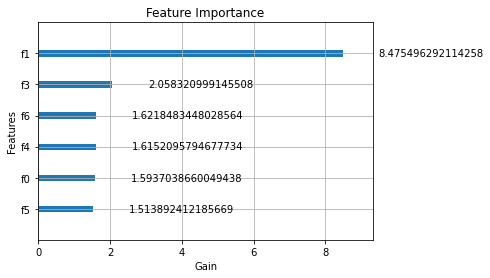

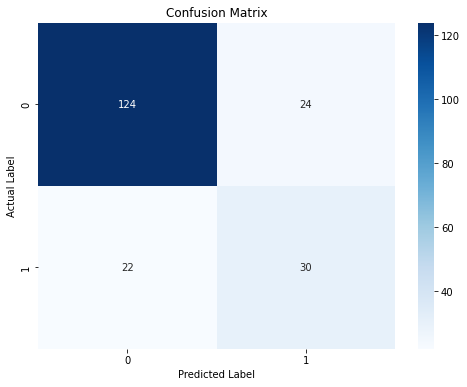

<Figure size 576x432 with 0 Axes>

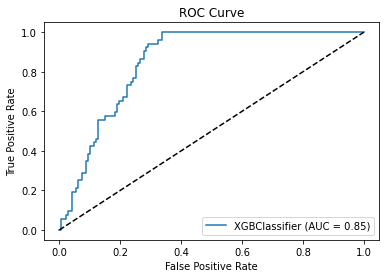

<Figure size 576x432 with 0 Axes>

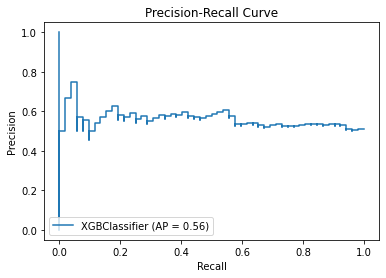

In [13]:
# Result Visualisations

# Feature Importance Visualisation
# This plot displays the importance of each feature in the model according to the 'gain' metric, which measures the average gain
# of splits which use the feature. A higher value means the feature is more important for making splits in trees.
plt.figure(figsize=(10, 7))
xgb.plot_importance(best_model, importance_type='gain')
plt.title('Feature Importance')
plt.ylabel('Features')  # The features of the dataset
plt.xlabel('Gain')  # The gain metric represents improvement in accuracy brought by a feature
plt.show()

# Confusion Matrix Visualisation
# The confusion matrix is a table used to describe the performance of a classification model. It shows the actual
# versus predicted labels. This visualisation helps identify how well the model is classifying each class.
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')  # Use seaborn's heatmap function to better visualise the matrix
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')  # The labels predicted by the model
plt.ylabel('Actual Label')  # The true labels from the dataset
plt.show()

# ROC Curve Visualisation
# The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability
# of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate against
# the False Positive Rate. The area under the curve (AUC) indicates the model's ability to distinguish between classes.
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], 'k--')  # Adds a diagonal dashed line representing the performance of a random classifier
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Precision-Recall Curve Visualisation
# This plot shows the trade-off between precision and recall for different thresholds. A high area under the curve
# represents both high recall and high precision, where high precision relates to a low false positive rate, and
# high recall relates to a low false negative rate. This curve is particularly useful for imbalanced datasets.
plt.figure(figsize=(8, 6))
PrecisionRecallDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')  # The ability of the classifier to find all the positive samples
plt.ylabel('Precision')  # The proportion of positive identifications that were actually correct
plt.show()


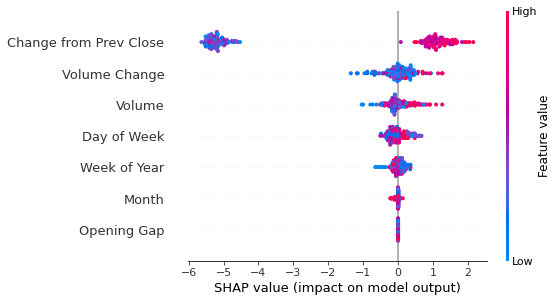

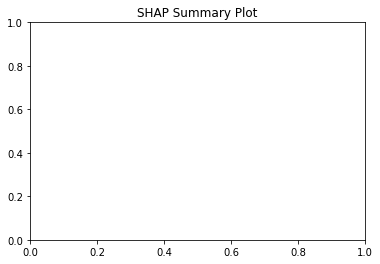

In [14]:
# Explainable ML using SHAP.

# SHAP values offer an approach to explain the output of any machine learning model by quantifying the impact of each feature on the prediction.
# These values are grounded in game theory, attributing the prediction output to the sum of effects of each feature being introduced into a conditional expectation.

# Initialise the SHAP Explainer
# The SHAP Explainer object is created for the best model obtained from the previous steps. It uses TreeExplainer internally for tree-based models like XGBoost.
explainer = shap.Explainer(best_model)

# Calculate SHAP Values
# SHAP values are calculated for the scaled test set, offering insights into how each feature in the dataset influences the prediction for each instance.
# These values help in understanding both the direction and magnitude of a feature's effect on the model output.
shap_values = explainer(X_test_scaled)

# Summary Plot of SHAP Values
# This visualisation aggregates the SHAP values for all features and all data points to provide a global view of model predictions.
# Features are sorted by the sum of SHAP value magnitudes across all samples, highlighting the overall impact of each feature on the model's output.
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns.tolist())
plt.title("SHAP Summary Plot")
plt.show()

# In the SHAP summary plot:
# - Each point represents a SHAP value for a feature and an instance.
# - The location on the y-axis is determined by the feature and on the x-axis by the SHAP value.
# - The color represents the value of the feature from low to high.
# - High SHAP values push the prediction higher (to the right), and low SHAP values push the prediction lower (to the left).
# - The plot provides a snapshot of which features are most important for the model and how values of those features impact the model's predictions.

# Using SHAP for explainable AI (XAI) ensures transparency in machine learning, allowing developers and stakeholders to understand the reasoning behind model predictions.
# It is especially crucial in sensitive and regulated industries, such as finance and healthcare, where understanding model predictions can inform better decision-making and ensure compliance.
